# "Kaplan-Meier curve of overall survival of cases stratified by the mRNA level of a certain gene in an independent cohort"

>"Only takes 3 min!"

- toc: falsem
- branch: master
- badges: true
- comments: false
- categories: [R, jupyter, microarry, survival]
- image: images/survival_gene.png
- hide: false

When dicovering genes and their function on deseases, survival curve is a good aspect to help us checking the influence of a factor (like genotype, RNA expression level, and age, gender). According to this pubilication [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3059453/), "the survival curve can be created assuming various situations. It involves computing of probabilities of occurrence of event at a certain point of time and multiplying these successive probabilities by any earlier computed probabilities to get the final estimate."

This note is about how I can make survival curve on a certain gene, and will keep it in update when I get new ideas later :)

Data source: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE53624

Public microarray RNA expression data of ESCC were retrieved from GEO database (GSE53624).

In [4]:
# Sys.setenv("VROOM_CONNECTION_SIZE"=999999)
# https://cran.r-project.org/web/packages/vroom/readme/README.html

library(AnnoProbe)
library(GEOquery) 



Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)



In [5]:
setwd("~/Documents/notes/")

In [6]:
dir.create("GSE53624",recursive = T)
eset <- getGEO("GSE53624", destdir = "./GSE53624", getGPL = F)

Found 1 file(s)

GSE53624_series_matrix.txt.gz



In [7]:
expr <- as.data.frame(exprs(eset[[1]]))
head(expr[,1:4])

,GSM1297076,GSM1297077,GSM1297078,GSM1297079
,<dbl>,<dbl>,<dbl>,<dbl>
1,14.196541,14.151714,13.796948,13.802610
2,3.195847,3.042514,3.211573,2.995495
24,15.261637,15.830739,15.311610,15.527160
25,3.157660,3.378073,3.165554,3.634285
26,5.277165,5.297271,5.193853,5.467351
27,8.545228,8.327291,8.527834,8.590668


Query probe annotation:

In [8]:
ids=idmap('GPL18109','pipe')
head(ids) 

file downloaded in /home/xiaofan/Documents/notes



,probe_id,symbol
,<int>,<chr>
1,80108,DDX11L1
2,80108,WASH7P
3,4320,DDX11L1
4,4320,WASH7P
5,97414,DDX11L1
6,97414,WASH7P


Find the target gene:

In [9]:
ids[ids$symbol=='CST1',]

,probe_id,symbol
,<int>,<chr>
80298,69686,CST1


,probe_id,symbol
,<int>,<chr>
38042,31250,CTSB


In [75]:
CST1 = expr[as.character(ids[ids$symbol=='CST1',1]),]
CST1

,GSM1297076,GSM1297077,GSM1297078,GSM1297079,GSM1297080,GSM1297081,GSM1297082,GSM1297083,GSM1297084,GSM1297085,⋯,GSM1297304,GSM1297305,GSM1297306,GSM1297307,GSM1297308,GSM1297309,GSM1297310,GSM1297311,GSM1297312,GSM1297313
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
69686,12.09817,8.922841,14.90663,10.18603,14.91623,10.18041,13.39866,9.199378,15.49725,11.30926,⋯,14.65862,9.33,13.42281,9.268775,13.32883,10.61139,11.57493,8.851528,13.1252,10.69054


In [76]:
CTSB = expr[as.character(ids[ids$symbol=='CTSB',1]),]
CTSB

,GSM1297076,GSM1297077,GSM1297078,GSM1297079,GSM1297080,GSM1297081,GSM1297082,GSM1297083,GSM1297084,GSM1297085,⋯,GSM1297304,GSM1297305,GSM1297306,GSM1297307,GSM1297308,GSM1297309,GSM1297310,GSM1297311,GSM1297312,GSM1297313
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
31250,14.60582,13.59123,14.5945,14.11498,15.0071,13.28104,14.32997,13.90693,14.7381,14.59319,⋯,14.90712,14.35302,14.5781,14.20684,13.92457,13.75713,14.54719,14.45429,14.85223,14.14271


Metadata:
GSE53624_clinical_data_of_patients_orignial_set.xls was downloaded from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE53624)

In [69]:
clinical <- xlsx::read.xlsx("./GSE53624/GSE53624_clinical_data_of_patients_orignial_set.xlsx",sheetIndex = 1) 

In [70]:
table(clinical$Death.at.FU) 


 no yes 
 46  73 

In [71]:
clinical$Death.at.FU <- gsub("no","0",
                             gsub("yes","1",clinical$Death.at.FU)) 
clinical_data <- data.frame(OS.time=as.numeric(clinical$Survival.time.months.),
                            OS=as.numeric(clinical$Death.at.FU),
                            sample=clinical$Patient.ID)
head(clinical_data)

,OS.time,OS,sample
,<dbl>,<dbl>,<chr>
1,48.766667,1,ec4
2,9.766667,1,ec6
3,5.833333,1,ec7
4,72.533333,0,ec9
5,72.633333,0,ec10
6,35.033333,1,ec11


In [72]:
phenotype <- pData(eset[[1]])
phe1 <- data.frame(sample = rownames(phenotype),
                   title = phenotype$title) 
phe1$tissue <- stringr::str_split(phe1$title," ",simplify = T)[,1]
phe1$patient <- stringr::str_split(phe1$title," ",simplify = T)[,5]
head(phe1)
phe1=phe1[phe1$tissue == 'cancer',]
phe1$patient=paste0('ec',phe1$patient)
identical(phe1$patient,clinical_data$sample)

,sample,title,tissue,patient
,<chr>,<chr>,<chr>,<chr>
1,GSM1297076,cancer tissue from patient 224,cancer,224
2,GSM1297077,normal tissue from patient 224,normal,224
3,GSM1297078,cancer tissue from patient 225,cancer,225
4,GSM1297079,normal tissue from patient 225,normal,225
5,GSM1297080,cancer tissue from patient 226,cancer,226
6,GSM1297081,normal tissue from patient 226,normal,226


[1] FALSE

In [73]:
library(survival)

In [77]:
CST1.clinical_data=clinical_data[match(phe1$patient,clinical_data$sample),]
CST1.cl=CST1[match(phe1$sample,colnames(expr))]
CST1.cl

,GSM1297076,GSM1297078,GSM1297080,GSM1297082,GSM1297084,GSM1297086,GSM1297088,GSM1297090,GSM1297092,GSM1297094,⋯,GSM1297294,GSM1297296,GSM1297298,GSM1297300,GSM1297302,GSM1297304,GSM1297306,GSM1297308,GSM1297310,GSM1297312
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
69686,12.09817,14.90663,14.91623,13.39866,15.49725,15.39298,14.39151,15.11474,15.29023,15.18338,⋯,12.50499,14.39441,10.29386,13.15363,12.39219,14.65862,13.42281,13.32883,11.57493,13.1252


In [80]:
CST1.cl=as.numeric(CST1.cl)

CST1.clinical_data$gene = ifelse( CST1.cl  > median( CST1.cl ),'high','low')
head(CST1.clinical_data)

,OS.time,OS,sample,gene
,<dbl>,<dbl>,<chr>,<chr>
65,60.30000,0,ec224,low
66,27.56667,1,ec225,high
67,34.66667,1,ec226,high
68,60.96667,0,ec227,low
81,15.43333,1,ec251,high
82,61.33333,0,ec253,high


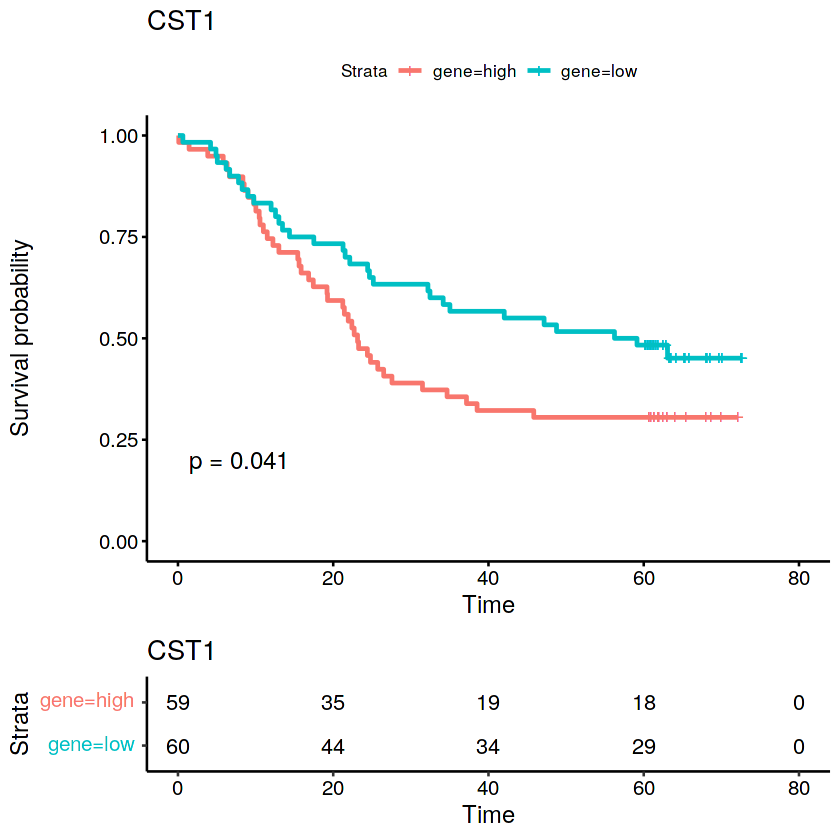

In [81]:
sfit1=survfit(Surv(OS.time, OS)~gene, data=CST1.clinical_data)
p1 = survminer::ggsurvplot(sfit1,pval =TRUE, data = CST1.clinical_data, risk.table = TRUE) + ggplot2::labs(title="CST1")
p1

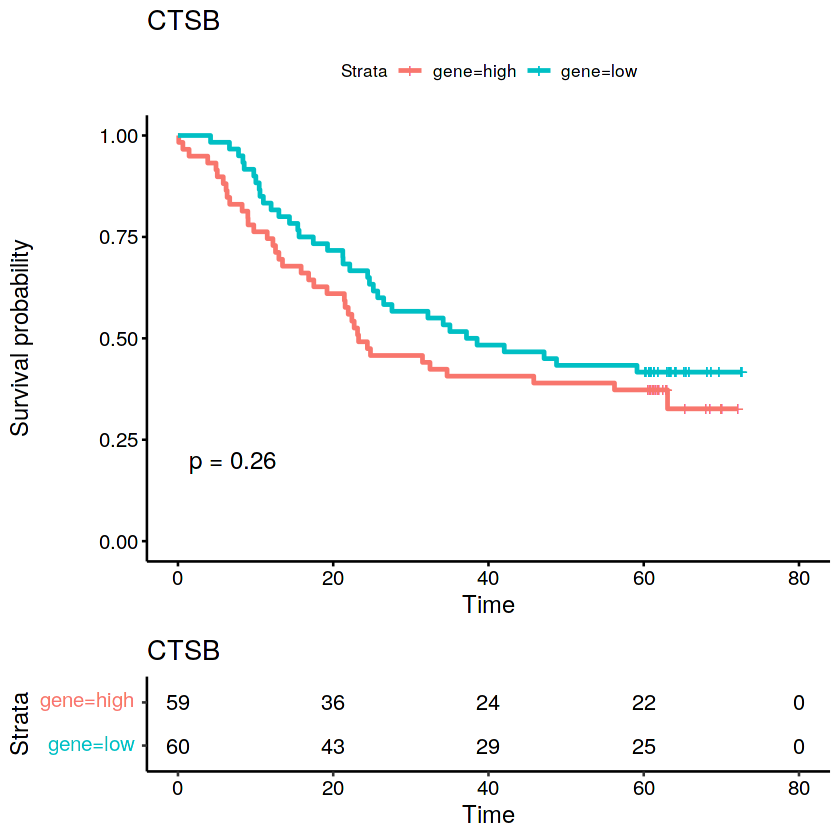

In [88]:
CTSB.clinical_data=clinical_data[match(phe1$patient,clinical_data$sample),]
CTSB.cl=CTSB[match(phe1$sample,colnames(expr))]
CTSB.cl=as.numeric(CTSB.cl)
CTSB.clinical_data$gene = ifelse( CTSB.cl  > median( CTSB.cl ),'high','low')
sfit2=survfit(Surv(OS.time, OS)~gene, data=CTSB.clinical_data)
p2 = survminer::ggsurvplot(sfit2,pval =TRUE, data = CTSB.clinical_data, risk.table = TRUE) + ggplot2::labs(title="CTSB")
p2

In [98]:
gene = "TTF1"
ids[ids$symbol=='TTF1',]


,probe_id,symbol
,<int>,<chr>
44153,49101,TTF1
44154,119532,TTF1
44155,103167,TTF1


In [101]:
TTF1 = expr[as.character(ids[ids$symbol==gene,1]),]
TTF1

,GSM1297076,GSM1297077,GSM1297078,GSM1297079,GSM1297080,GSM1297081,GSM1297082,GSM1297083,GSM1297084,GSM1297085,⋯,GSM1297304,GSM1297305,GSM1297306,GSM1297307,GSM1297308,GSM1297309,GSM1297310,GSM1297311,GSM1297312,GSM1297313
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
49101,11.02987,10.80374,10.91583,10.62685,11.44957,10.91205,10.83738,10.77016,10.19814,10.18317,⋯,10.30097,10.15997,11.37990,10.83498,11.03148,10.65352,10.39791,10.39283,10.33114,9.444365
119532,11.71704,11.47166,11.61420,11.28658,12.13650,11.59252,11.56784,11.47886,11.26517,11.29613,⋯,11.07106,10.85781,11.89306,11.29598,11.60490,11.25663,11.00526,10.97788,10.99330,10.568630
103167,10.93233,10.77753,10.86874,10.84316,11.39397,10.94832,10.83884,10.89749,11.42119,11.34206,⋯,10.10479,10.09412,11.42420,10.70688,10.81011,10.55752,10.34643,10.31036,10.38547,9.385584


In [103]:
TTF1 = expr[49101,]
TTF1
PTEN=TTF1

,GSM1297076,GSM1297077,GSM1297078,GSM1297079,GSM1297080,GSM1297081,GSM1297082,GSM1297083,GSM1297084,GSM1297085,⋯,GSM1297304,GSM1297305,GSM1297306,GSM1297307,GSM1297308,GSM1297309,GSM1297310,GSM1297311,GSM1297312,GSM1297313
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
79066,6.391043,7.798494,5.072013,7.196961,6.798004,9.259991,5.799467,6.866773,3.912495,7.193734,⋯,7.867408,9.985494,4.70194,6.216463,4.815819,4.557891,5.632451,6.549177,4.005441,5.385023


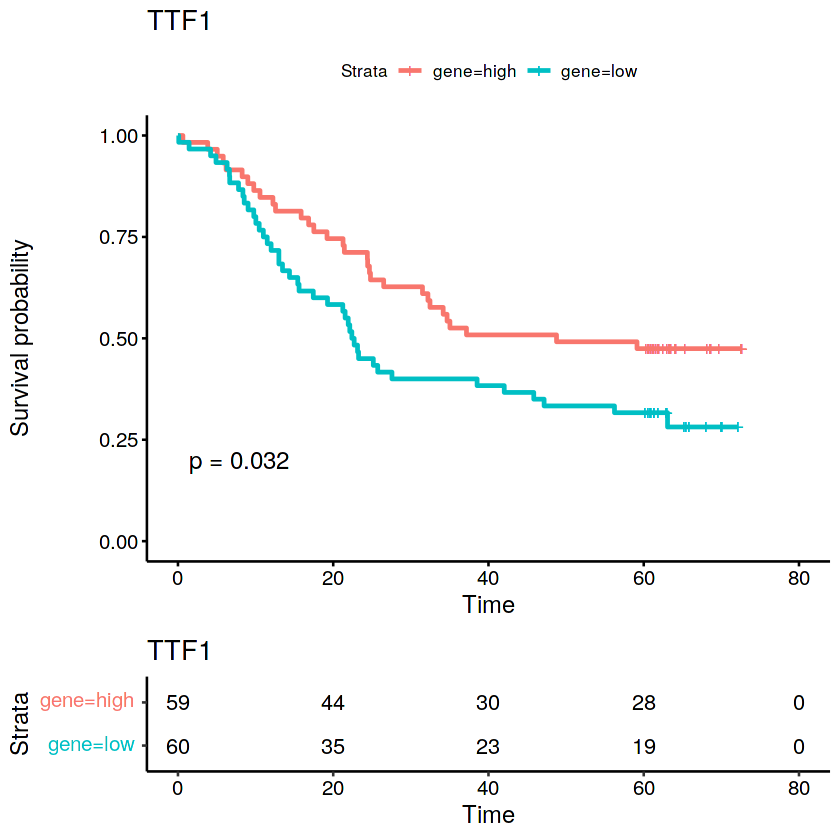

In [105]:
TTF1.clinical_data=clinical_data[match(phe1$patient,clinical_data$sample),]
TTF1.cl=as.numeric(TTF1[match(phe1$sample,colnames(expr))])
TTF1.clinical_data$gene = ifelse( TTF1.cl  > median( TTF1.cl ),'high','low')
sfit3=survfit(Surv(OS.time, OS)~gene, data=TTF1.clinical_data)
survminer::ggsurvplot(sfit3,pval =TRUE, data = TTF1.clinical_data, risk.table = TRUE) + ggplot2::labs(title="TTF1")

In [87]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.8.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=en_US.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=en_US.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=en_US.UTF-8          LC_NAME=en_US.UTF-8          
 [9] LC_ADDRESS=en_US.UTF-8        LC_TELEPHONE=en_US.UTF-8     
[11] LC_MEASUREMENT=en_US.UTF-8    LC_IDENTIFICATION=en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] survival_3.3-1      GEOquery_2.62.2     Biobase_2.54.0     
[4] BiocGenerics_0.40.0 AnnoProbe_0.1.6    

loaded via a namespace (and not attached):
 [1] ggtext_0.1.1       RColorBrewer_1.1-3 repr_1.1.4         tools_4.